<a href="https://colab.research.google.com/github/parmigggiana/ml-ids/blob/main/IDS_CTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attack detection using CTF dataset

You shouldn't use 'Run All' on this notebook: in the sections 'Dimensionality Reduction' and 'Training' only run one of the subsections for each.
If you run all the cells it won't cause any error, just waste time on operations that will then be overwritten.

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.cluster import KMeans, MeanShift, FeatureAgglomeration
from pandas.plotting import scatter_matrix

%matplotlib inline

## Utility Functions

In [45]:
def print_scores(y_test, y_pred):
    auroc = metrics.roc_auc_score(y_test, y_pred)
    if auroc < 0.5:
        y_pred = [0 if x == 1 else 1 for x in y_pred] # If it's worse than random guessing we flip it - we're not cheating here, the prediction just doesn't have a concept of benign or attack, it just identifies two clusters. if auroc was less than 0.5 it means we labelled them wrong
        auroc = metrics.roc_auc_score(y_test, y_pred)
    Accuracy = metrics.accuracy_score(y_test, y_pred)
    Precision = metrics.precision_score(y_test, y_pred)
    Recall = metrics.recall_score(y_test, y_pred)
    F1 = metrics.f1_score(y_test, y_pred)
    fpr, tpr, threasholds = metrics.roc_curve(y_test, y_pred)
    """ 
    Confusion matrix:

        0  1 - predicted value (Wikipedia uses different convention for axes)
        0 TN FP
        1 FN TP 
    """
    print(metrics.confusion_matrix(y_test, y_pred))
    print(f"{Accuracy = }")
    print(f"{Precision = }")
    print(f"{Recall = }")
    print(f"Area Under ROC Curve = {auroc}")
    print(f"{F1 = }")
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.show()

In [25]:
def load_test(scaler, dimred):
    if 'test_df' not in globals():
        test_df = pd.read_csv(filepath_or_buffer="definitive_dataset.csv")

    y_test = test_df["Label"]
    X_test = test_df.drop(columns="Label")
    X_test = scaler.transform(X_test)
    X_test = dimred.transform(X_test)

    return X_test, y_test

In [26]:
def visualize_features(X):
    corr_matrix = pd.DataFrame(X).corr()
    plt.rcParams['figure.figsize'] = (18, 8)
    g = sns.heatmap(corr_matrix, annot=True, fmt=".1g", cmap="Greys")
    g.set_xticklabels(
        g.get_xticklabels(),
        verticalalignment="top",
        horizontalalignment="right",
        rotation=30,
    )
    plt.show()
    scatter_matrix(pd.DataFrame(X), alpha=0.2, figsize=(20, 20), diagonal="kde")

## Data preparation

In [27]:
!wget https://github.com/parmigggiana/ml-ids/raw/main/CTF%20Data/Thu15.csv -O dataset_ctf.csv
    

--2023-06-19 21:39:33--  https://github.com/parmigggiana/ml-ids/raw/main/CTF%20Data/Thu15.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/parmigggiana/ml-ids/main/CTF%20Data/Thu15.csv [following]
--2023-06-19 21:39:34--  https://raw.githubusercontent.com/parmigggiana/ml-ids/main/CTF%20Data/Thu15.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54741471 (52M) [text/plain]
Saving to: ‘dataset_ctf.csv’

dataset_ctf.csv     100%[===================>]  52.21M  6.22MB/s    in 9.9s    

2023-06-19 21:39:48 (5.28 MB/s) - ‘dataset_ctf.csv’ saved [54741471/54741471]



In [28]:
df = pd.read_csv("CTF Data/Thu15.csv")
df.shape

(79819, 89)

Make sure that there's no null rows

In [29]:
df = df.drop(df[pd.isnull(df["Flow ID"])].index)
df.shape

(79819, 89)

Drop Label column since it's useless

In [30]:
df.drop(columns="Label", inplace=True)
df.shape

(79819, 88)

Drop all flows pertaining ssh and caronte

In [31]:
df.drop(df[df["Src Port"] == 22].index, inplace=True)
df.drop(df[df["Dst Port"] == 22].index, inplace=True)
df.drop(df[df["Src Port"] == 3333].index, inplace=True)
df.drop(df[df["Dst Port"] == 3333].index, inplace=True)
df.shape

(79472, 88)

Drop all flows made by our team

In [32]:
df.drop(df[df["Src IP"].str.fullmatch(r"10\.80\.39\.\d{1,3}")].index, inplace=True)
df.drop(df[df["Dst IP"].str.fullmatch(r"10\.80\.39\.\d{1,3}")].index, inplace=True)
df.shape

(79471, 88)

In [33]:
df["Src IP"].unique()

array(['10.254.0.1', '10.80.35.2', '172.23.0.2', '10.80.24.6',
       '10.80.36.6', '10.80.24.12', '10.80.22.2', '10.80.36.8',
       '10.80.22.6', '10.80.35.3', '10.80.20.2', '10.80.6.4', '10.80.5.7',
       '10.80.22.4', '10.80.36.9', '10.80.32.2', '10.80.35.7',
       '10.80.22.7', '10.60.39.1', '10.80.21.4', '10.80.22.5',
       '10.80.36.7', '10.80.22.3', '10.80.30.2', '10.80.26.6'],
      dtype=object)

I noticed there's 1784 flows belonging to other addresses. This probably means there's an error in the gameserver, leaking some packets. Upon manual inspection of the pcap, I noticed they are mostly FIN/ACK and RST. 
I chose to keep these flows as it's still actual traffic and we will be removing the IP features anyway

In [34]:
df[
    ((df["Src IP"] != "10.254.0.1") & (df["Src IP"] != "10.60.39.1"))
    | ((df["Dst IP"] != "10.254.0.1") & (df["Dst IP"] != "10.60.39.1"))
].shape

(1782, 88)

The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

In [35]:
df.replace("Infinity", -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(
    pd.to_numeric
)

Replace the NaN values and infinity values with -1.

In [36]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [37]:
excluded = [
    "Flow ID",
    "Src IP",
    "Src Port",
    "Dst IP",
    "Dst Port",
    "Protocol",
    "Timestamp",
]
df.drop(columns=excluded, inplace=True)

## Dimensionality Reduction

We don't have labels to select features based on importance. A simple approach would be using the same features selected on the CIC-IDS-2017 Dataset 

### Feature Selection

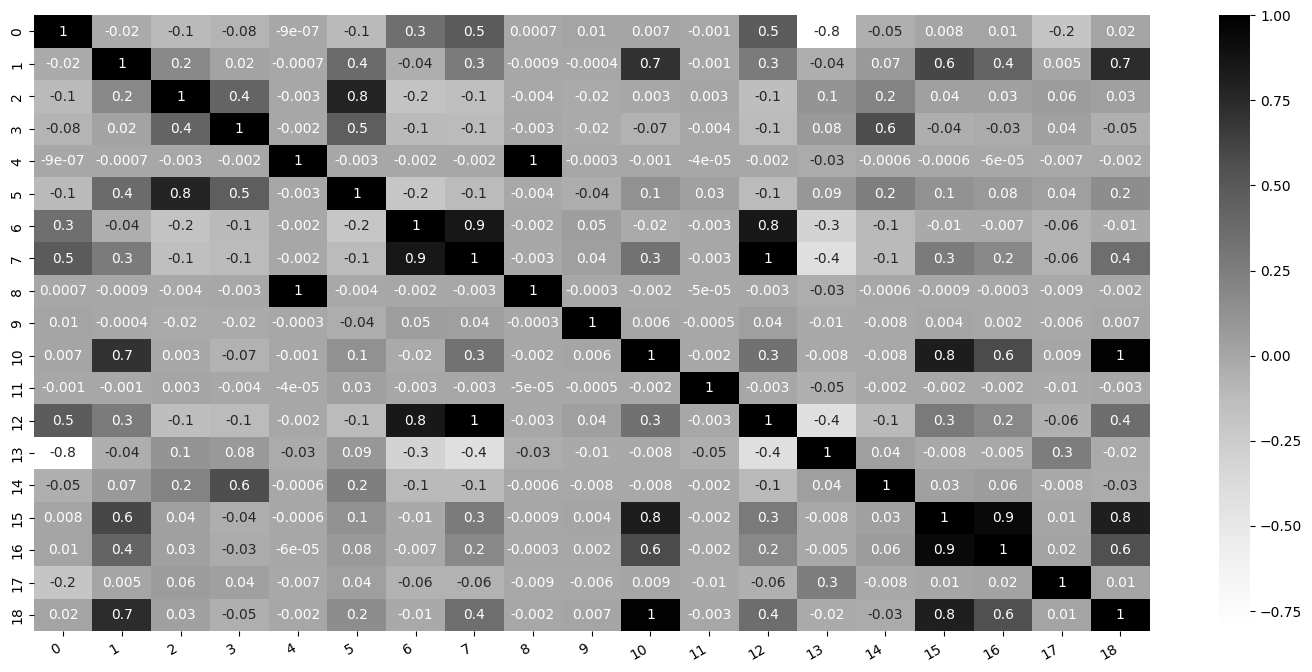

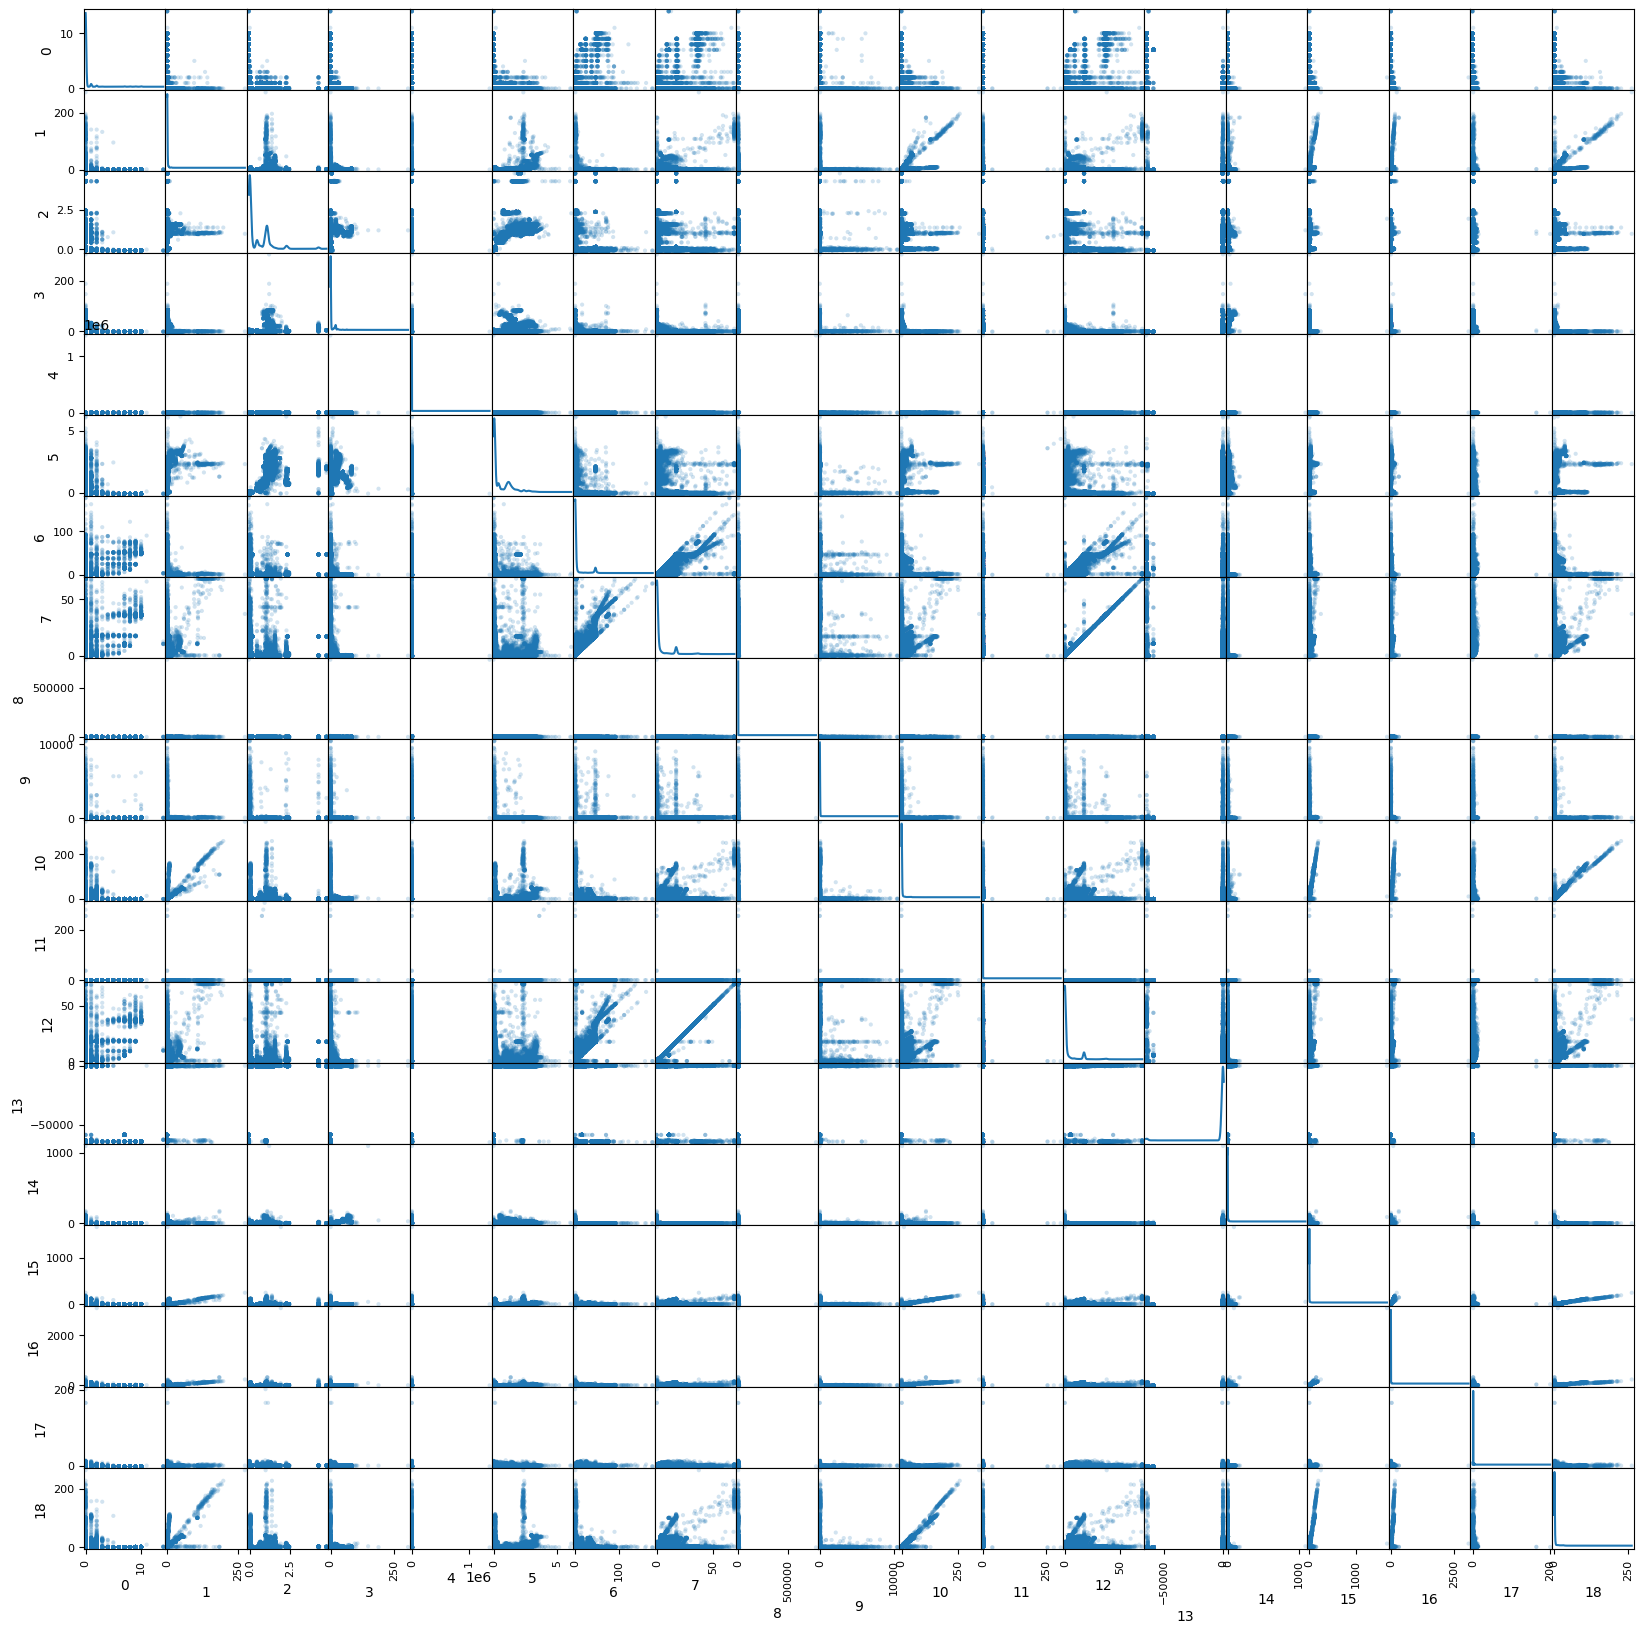

In [38]:
features = [
    "RST Flag Count",
    "Total Length of Fwd Packet",
    "Fwd Packet Length Max",
    "Packet Length Variance",
    "Fwd Packets/s",
    "Fwd Packet Length Mean",
    "Flow IAT Max",
    "Flow Duration",
    "Flow Packets/s",
    "Total TCP Flow Time",
    "PSH Flag Count",
    "Packet Length Min",
    "Bwd IAT Total",
    "FWD Init Win Bytes",
    "Flow Bytes/s",
    "ACK Flag Count",
    "Fwd Header Length",
    "SYN Flag Count",
    "Total Bwd packets",
]
X = df[features]
scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)

visualize_features(X)

We can see how many of the selected features are practically independent from the dataset. This means they don't bring much information.

### PCA

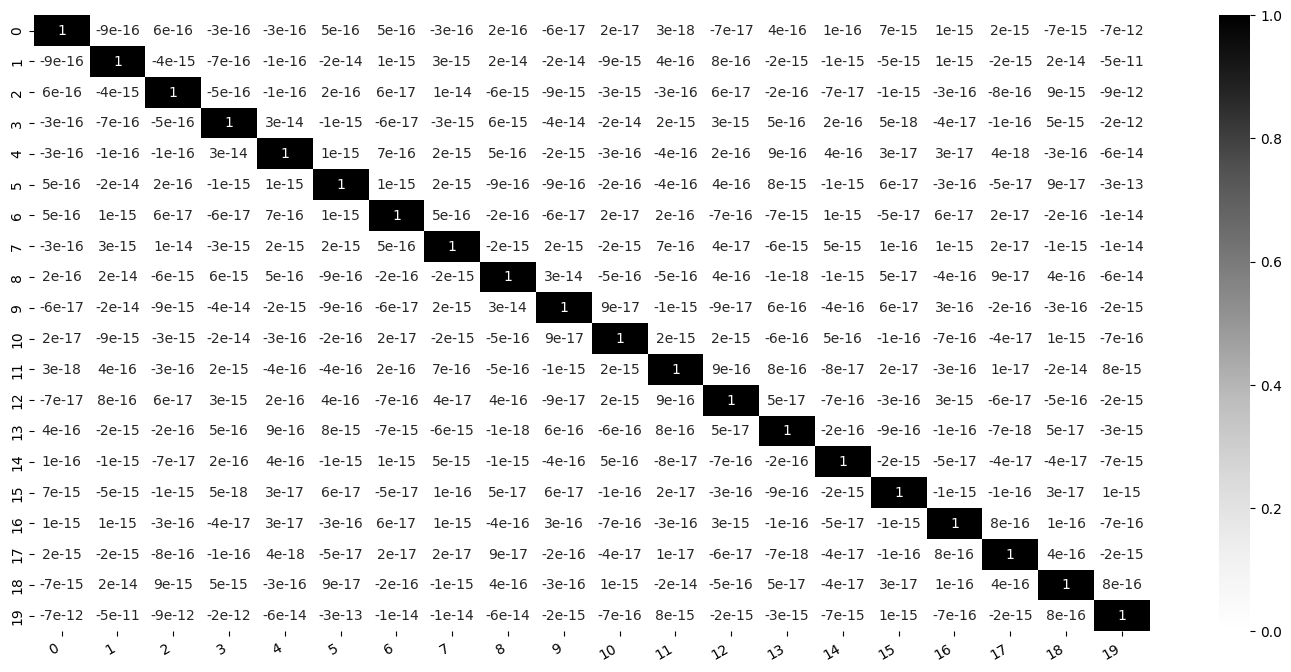

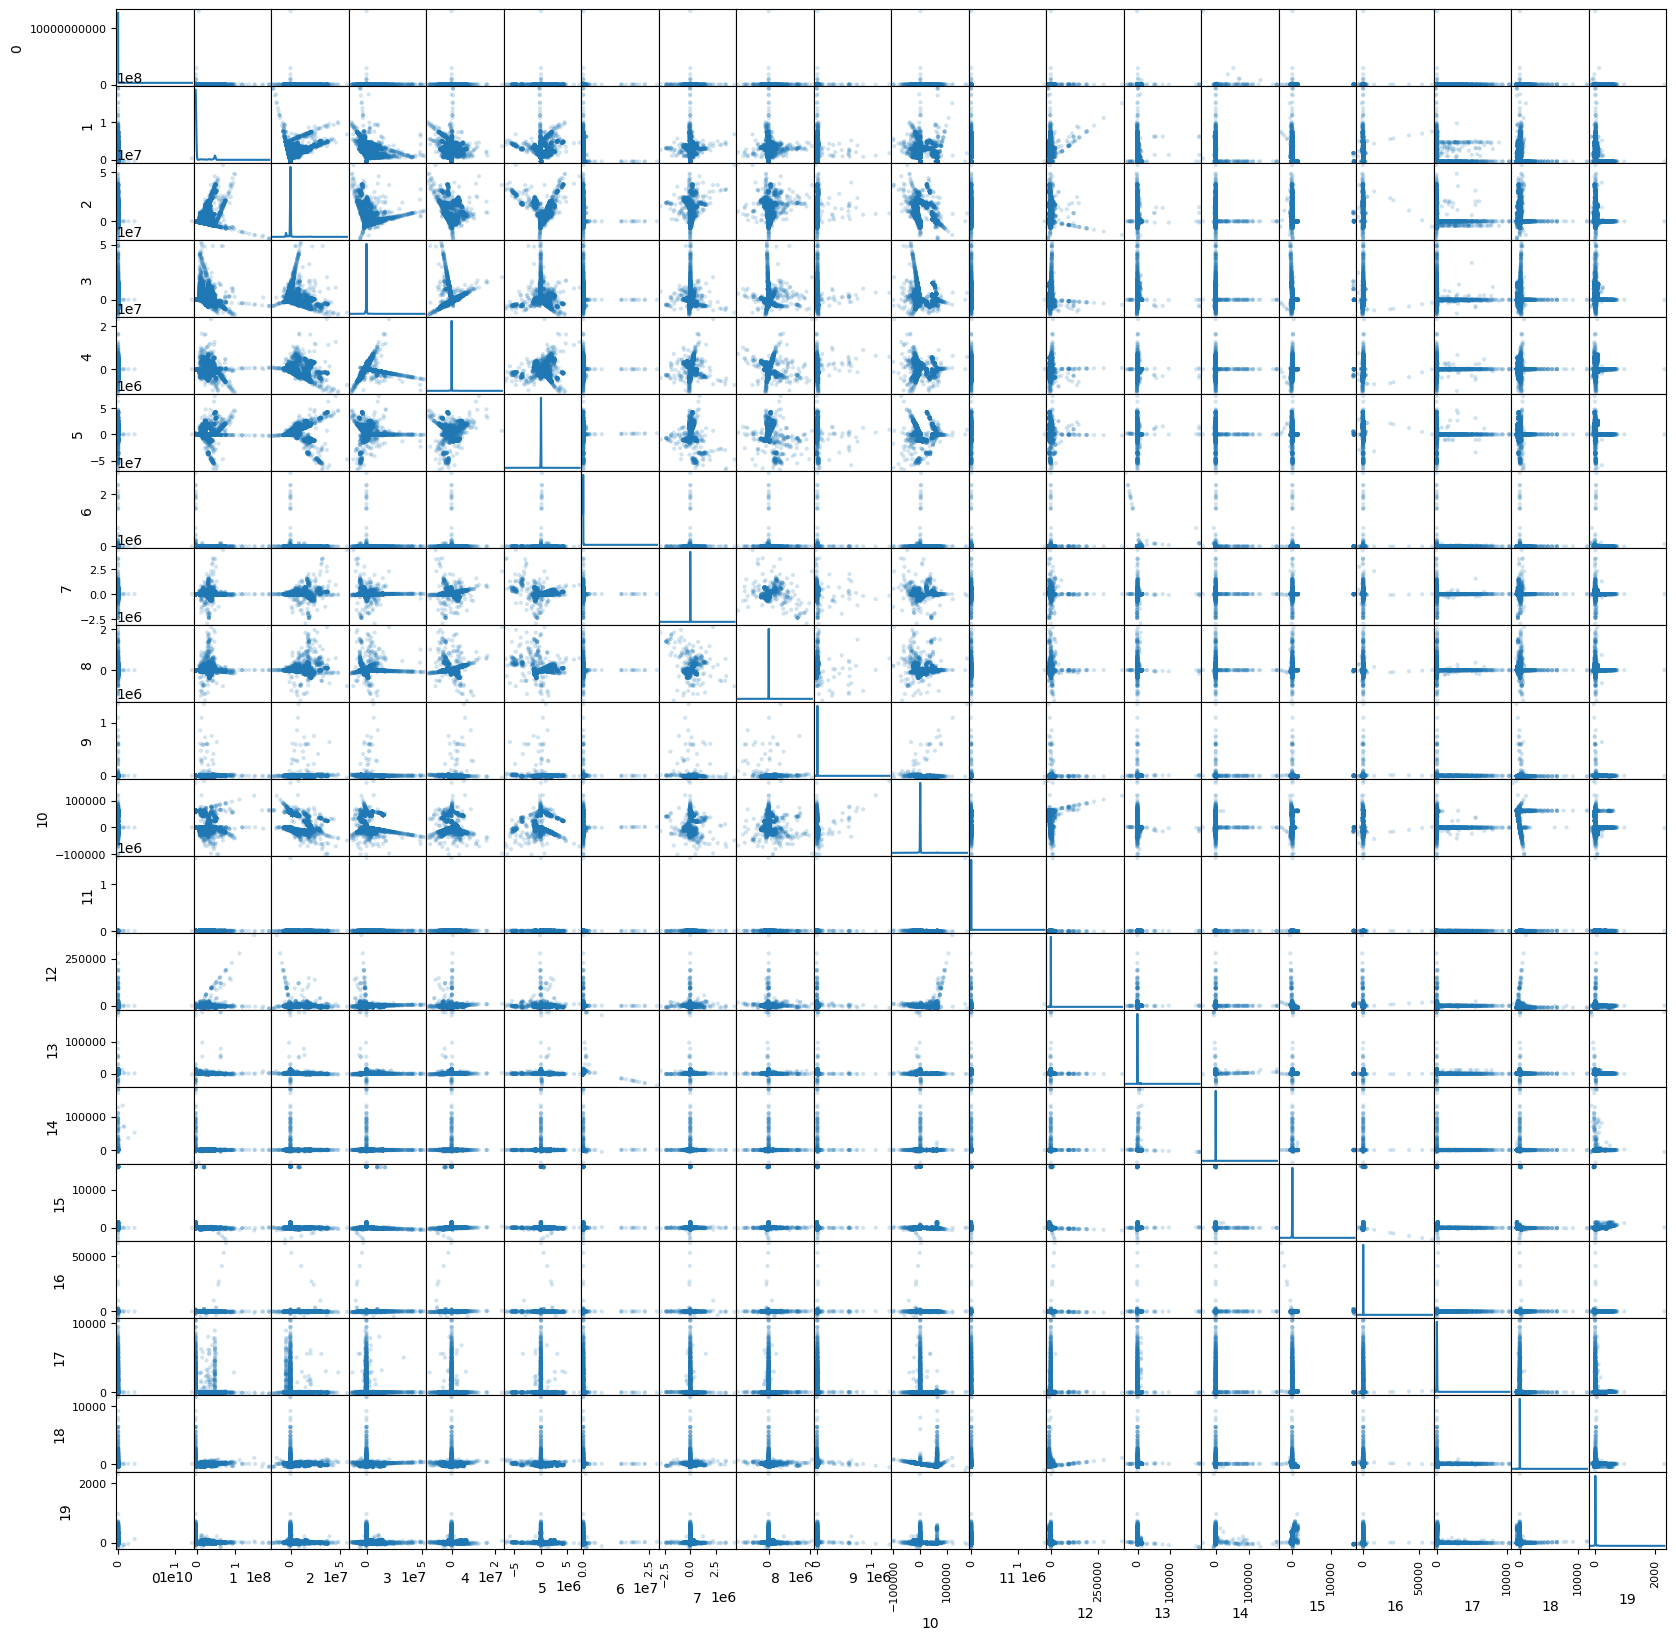

In [39]:
scaler = RobustScaler()
scaler.fit(df)
X = scaler.transform(df)

dimred = PCA(20, random_state=42)
dimred.fit(X)
X = dimred.transform(X)

visualize_features(X)

### Feature Agglomeration

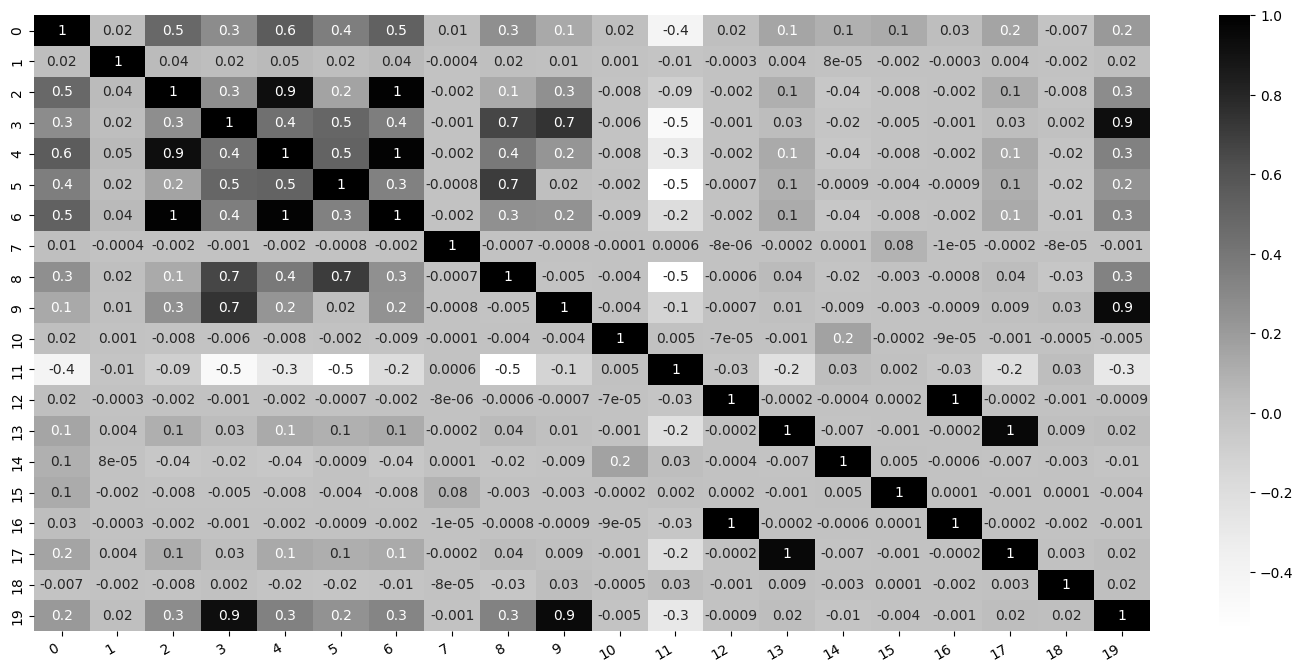

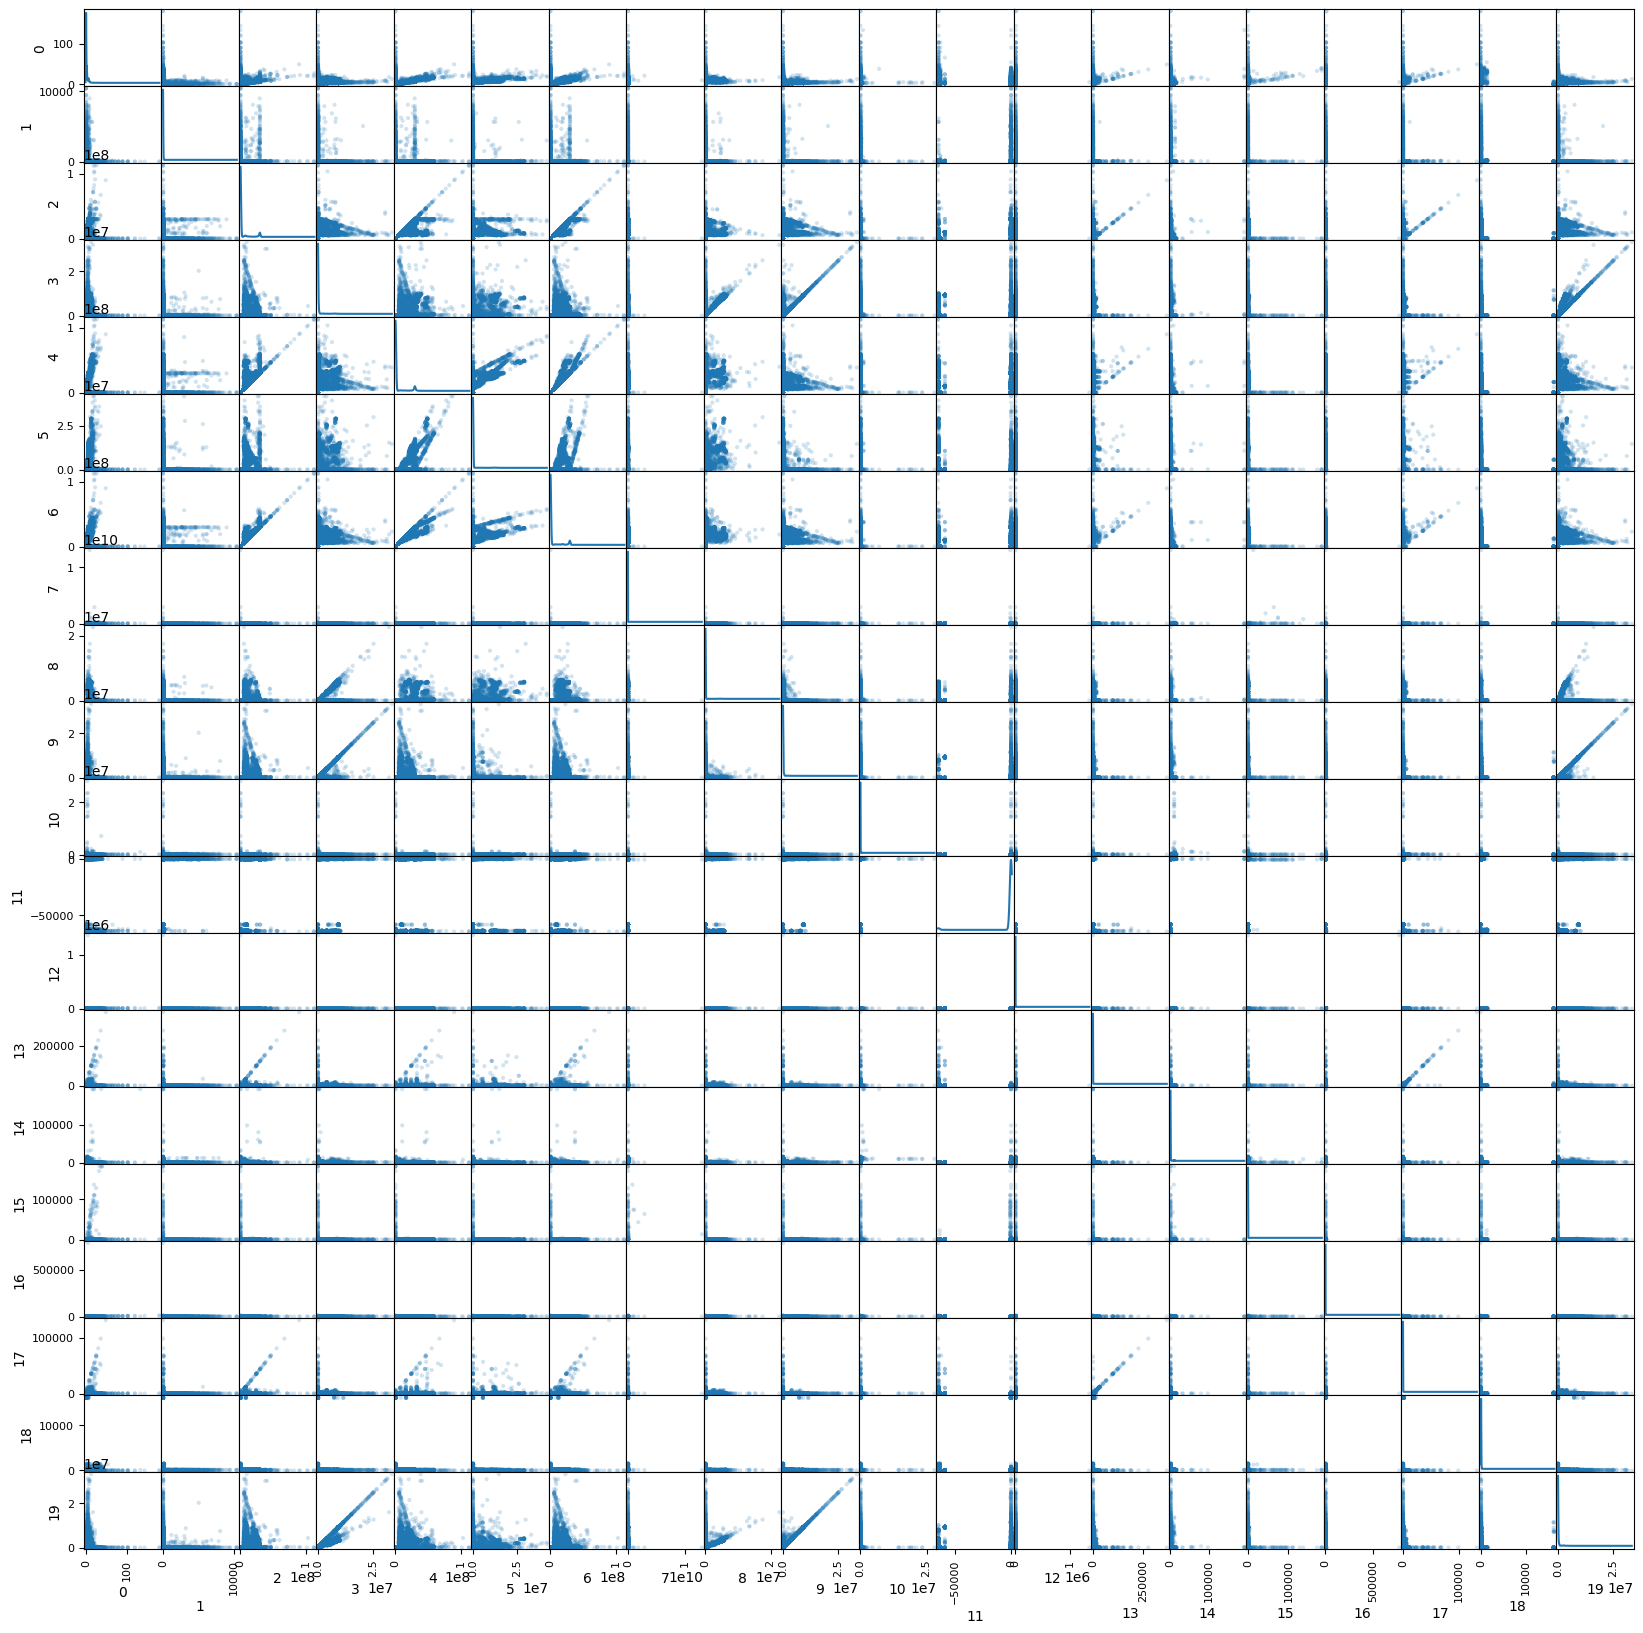

In [40]:
scaler = RobustScaler()
scaler.fit(df)
X = scaler.transform(df)

dimred = FeatureAgglomeration(n_clusters=20)
dimred.fit(X)
X = dimred.transform(X)

visualize_features(X)

## Training


In [41]:
clf: KMeans = KMeans(2, random_state=42, verbose=10)

param_grid = {
    "algorithm": ["lloyd", "elkan"],
    "max_iter": [100, 300, 650, 1000, 2000],
    "n_init": [1, 2, 5, 10, 20],
}
search = HalvingGridSearchCV(clf, param_grid=param_grid, n_jobs=-1, verbose=10).fit(X)
clf: KMeans = search.best_estimator_

X_test, y_test = load_test(scaler, dimred)
y_pred = clf.predict(X_test)
print(search.best_estimator_)
print(search.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 2943
max_resources_: 79471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 2943
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START algorithm=lloyd, max_iter=100, n_init=1....................
Initialization complete
Iteration 0, inertia 9.895633116131384e+16.
Iteration 1, inertia 8.056867372721965e+16.
Iteration 2, inertia 8.051205802461112e+16.
Iteration 3, inertia 8.05097175999605e+16.
Converged at iteration 3: strict convergence.
[CV 1/5; 1/50] END algorithm=lloyd, max_iter=100, n_init=1;, score=(train=-80509717599960480.000, test=-7533680383219333.000) total time=   0.1s
[CV 1/5; 4/50] START algorithm=lloyd, max_iter=100, n_init=10...................
Initialization complete
Iteration 0, inertia 9.895633116131384e+16.
Iteration 1, inertia 8.056867372721965e+16.
Iteration 2, inertia 8.051205802461112e+16.
Iteration 3, inertia 8.0509

### MeanShift

In [42]:
clf = MeanShift(max_iter=300, n_jobs=-1)
clf.fit(X)

"""
MeanShift outputs 107 classes. To project them into binary I iteratively tried considering every class a benign or not, maximizing the F1 score on the test dataset (Corrected CIC-IDS-2017). 
"""
X_test, y_test = load_test(scaler, dimred)
y_pred = clf.predict(X_test)

benign_classes = []
y_pred_tmp = y_pred.tolist()
classes = np.unique(y_pred)
for c in classes:
    y_pred_ben = [0 if x == c else x for x in y_pred_tmp]
    y_pred_att = [1 if x == c else x for x in y_pred_tmp]

    y_pred_ben = [1 if x != 0 else x for x in y_pred_ben]
    y_pred_att = [1 if x != 0 else x for x in y_pred_att]

    F1_B = metrics.f1_score(y_test, y_pred_ben)
    F1_A = metrics.f1_score(y_test, y_pred_att)

    print(f"F1 with class {c} as BENIGN: {F1_B}")
    print(f"F1 with class {c} as ATTACK: {F1_A}")
    print("\n")
    if F1_B > F1_A:
        benign_classes.append(c)
    y_pred_tmp = [0 if x in benign_classes else x for x in y_pred]

# print(f"{benign_classes = }")
y_pred = [1 if x != 0 else x for x in y_pred_tmp]

F1 with class 0 as BENIGN: 0.3727808046227693
F1 with class 0 as ATTACK: 0.46140384510050936


F1 with class 1 as BENIGN: 0.37374316395839746
F1 with class 1 as ATTACK: 0.3727808046227693


F1 with class 2 as BENIGN: 0.38002350671733437
F1 with class 2 as ATTACK: 0.37374316395839746


F1 with class 3 as BENIGN: 0.3798362040897569
F1 with class 3 as ATTACK: 0.38002350671733437


F1 with class 4 as BENIGN: 0.36063447738852006
F1 with class 4 as ATTACK: 0.38002350671733437


F1 with class 5 as BENIGN: 0.38066233841700164
F1 with class 5 as ATTACK: 0.38002350671733437


F1 with class 6 as BENIGN: 0.38003514248099546
F1 with class 6 as ATTACK: 0.38066233841700164


F1 with class 7 as BENIGN: 0.3804363924887595
F1 with class 7 as ATTACK: 0.38066233841700164


F1 with class 8 as BENIGN: 0.3802780046466264
F1 with class 8 as ATTACK: 0.38066233841700164


F1 with class 9 as BENIGN: 0.3804348257036414
F1 with class 9 as ATTACK: 0.38066233841700164


F1 with class 10 as BENIGN: 0.380002378781271


### Isolation Forest

In [43]:
clf: IsolationForest = IsolationForest(
    n_estimators=200, max_features=10, bootstrap=True, random_state=42, verbose=1
)

clf.fit(X)

X_test, y_test = load_test(scaler, dimred)
y_pred = clf.predict(X_test)  # output is -1 | 1
y_pred = [0 if x == -1 else 1 for x in y_pred]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


## Testing

[[524546 655432]
 [ 88223 417208]]
Accuracy = 0.5587688210992109
Precision = 0.3889543556085919
Recall = 0.8254499625072463
Area Under ROC Curve = 0.6349943794966413
F1 = 0.5287569443960379


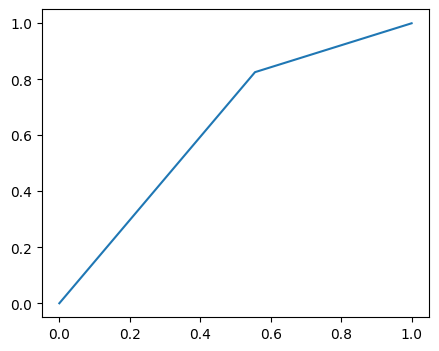

In [46]:
print_scores(y_test, y_pred)